In [15]:
import dspy, os
from langgraph.graph import StateGraph, START, END
from agents.dspy_modules import create_agent_response, agent_reply
from config.settings import PERPLEXITY_API_KEY, TOP_K_DISEASES, MAX_ITERATIONS
from typing import TypedDict, List, Dict, Any

os.environ["PERPLEXITY_API_KEY"] = PERPLEXITY_API_KEY

lm = dspy.LM("perplexity/sonar-pro")  
dspy.settings.configure(lm=lm)


In [2]:
# test
from litellm import completion
messages = [
    {"role": "user", "content": "Two dice are tossed. What is the probability that the sum equals two?"}
]
response = completion(
    model="perplexity/sonar-pro", 
    messages=messages,
    stream=True
)
for chunk in response:
    print(chunk["choices"][0]["delta"].get("content", ""), end="", flush=True)

When two dice are tossed, there are **36 possible outcomes** (since each die has 6 faces, so \(6 \times 6 = 36\))[2][5].

For the **sum to equal two**, both dice must show a 1, which is the outcome (1, 1)[4][5]. This is the only way to achieve that sum.

- **Number of favorable outcomes:** 1 (just (1, 1))
- **Number of possible outcomes:** 36

So, the probability is:

\[\text{Probability} = \frac{1}{36}
\]

**The probability that the sum equals two when two dice are tossed is \(\frac{1}{36}\)[4].**None

In [16]:
agents = ["geneticist", "radiologist", "clinician"]
M = MAX_ITERATIONS
K = TOP_K_DISEASES

class AgentState(TypedDict):
    conversation: List[Any]
    pending_questions: List[Dict[str, Any]]
    symptoms: List[str]

class State(TypedDict):
    symptoms: List[str]
    handler_summary: Dict[str, Any]
    agent_states: Dict[str, Any]
    round_num: int
    round_blocks: List[Dict[str, Any]]

In [17]:
def handler_node(state):
    handler_summary = create_agent_response("handler", state["symptoms"], context="")
    state["handler_summary"] = handler_summary
    state["agent_states"] = {
        agent: {
            "conversation": [],
            "pending_questions": [],
            "symptoms": state["symptoms"]
        } for agent in agents
    }
    for agent in agents:
        result = create_agent_response(agent, state["symptoms"], context="")
        print(result)
        state["agent_states"][agent]["conversation"].append(result)
        if result.get("questions"):
            qs = result["questions"]
            if isinstance(qs, dict):
                for to_agent, q in qs.items():
                    if to_agent in agents:
                        state["agent_states"][to_agent]["pending_questions"].append({"from": agent, "to": to_agent, "question": q})
            elif isinstance(qs, list):
                for qitem in qs:
                    if isinstance(qitem, dict) and "to" in qitem and "question" in qitem:
                        to_agent = qitem["to"]
                        if to_agent in agents:
                            state["agent_states"][to_agent]["pending_questions"].append({"from": agent, "to": to_agent, "question": qitem["question"]})
    state["round_num"] = 1
    return state

In [18]:
def agent_round_node(state):
    
    new_agent_states = {
        a: {**v, "pending_questions": []}
        for a, v in state["agent_states"].items()
    }

    round_outputs = {}
    for agent in agents:
        agent_state = state["agent_states"][agent]
        symptoms = agent_state["symptoms"]
        conversation = agent_state["conversation"]
        pending = [q for q in agent_state["pending_questions"] if q["to"] == agent]
        if pending:
            all_qs = "\n".join([f"From {q['from']}: {q['question']}" for q in pending])
            result = agent_reply(agent, symptoms, all_qs, str(conversation))
        else:
            result = create_agent_response(agent, symptoms, str(conversation))
        new_agent_states[agent]["conversation"].append(result)
        round_outputs[agent] = result
        if result.get("questions"):
            qs = result["questions"]
            if isinstance(qs, dict):
                for to_agent, q in qs.items():
                    if to_agent in agents:
                        new_agent_states[to_agent]["pending_questions"].append({"from": agent, "to": to_agent, "question": q})
            elif isinstance(qs, list):
                for qitem in qs:
                    if isinstance(qitem, dict) and "to" in qitem and "question" in qitem:
                        to_agent = qitem["to"]
                        if to_agent in agents:
                            new_agent_states[to_agent]["pending_questions"].append({"from": agent, "to": to_agent, "question": qitem["question"]})
    state["agent_states"] = new_agent_states
    if "round_blocks" not in state:
        state["round_blocks"] = []
    state["round_blocks"].append(round_outputs)
    state["round_num"] += 1
    return state

In [19]:
def should_continue(state):
    if state["round_num"] > M:
        return END
    return "agent_round"

def build_graph():
    workflow = StateGraph(State)  
    workflow.add_node("handler", handler_node)
    workflow.add_edge(START, "handler")
    workflow.add_edge("handler", "agent_round")

    workflow.add_node("agent_round", agent_round_node)
    workflow.add_conditional_edges(
        "agent_round",
        should_continue,
        {"agent_round": "agent_round", END: END}
    )

    workflow.add_edge("handler", END)

    return workflow

def visualize_graph(graph):
    from IPython.display import Image, display

    try:
        display(Image(graph.get_graph().draw_mermaid_png()))
    except Exception:
        print('Error generating graph')
        pass

In [22]:
def main(symptoms):
    state = {"symptoms": symptoms}

    workflow = build_graph()
    app = workflow.compile()
    
    visualize_graph(app)
    
    final_state = app.invoke(state)
    
    handler_summary = final_state["handler_summary"]
    
    print("# HANDLER SUMMARY\n" + "="*50)
    print(f"Response: {handler_summary['response']}")
    if handler_summary.get("questions"):
        print(f"Questions: {handler_summary['questions']}")
    print(f"Confidence: {handler_summary['confidence']}")
    print(f"Diseases: {handler_summary['diseases']}")
    print()
    
    for round_idx, round_outputs in enumerate(final_state["round_blocks"]):
        print(f"# ROUND {round_idx+1}\n" + "-"*40)
        for agent in agents:
            response = round_outputs[agent]
            print(f"## {agent.upper()}")
            print(f"Response: {response['response']}")
            if response.get("questions"):
                print(f"Questions: {response['questions']}")
            print(f"Confidence: {response['confidence']}")
            print(f"Diseases: {response['diseases']}")
            print()
    
    disease_conf = {}
    for agent in agents:
        for resp in final_state["agent_states"][agent]["conversation"]:
            diseases = resp.get("diseases")
            if isinstance(diseases, str):
                diseases = [d.strip() for d in diseases.split(",")]
            elif not isinstance(diseases, list):
                continue  # skip if it's neither str nor list
            
            for d in diseases:
                try:
                    conf = float(resp.get("confidence", 0))
                except Exception:
                    conf = 0.0
                disease_conf[d] = disease_conf.get(d, 0) + conf
                
    top3 = sorted(disease_conf.items(), key=lambda x: -x[1])[:3]
    print("# TOP 3 DISEASES (by aggregated confidence)")
    for d, c in top3:
        print(f"- {d}: {c:.2f}")

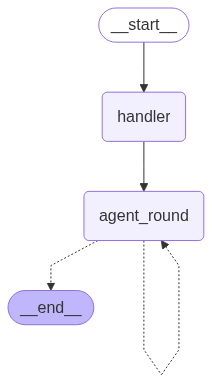

{'agent_type': 'geneticist', 'response': 'From a genetic perspective, the combination of **fever, rash, and fatigue** suggests the possibility of a rare hereditary autoinflammatory syndrome. These disorders are characterized by recurrent or periodic fevers, often accompanied by skin manifestations and systemic symptoms such as fatigue. Based on the symptoms and available evidence, the following rare genetic diseases are considered:\n\n1. **Familial Mediterranean Fever (FMF)**  \n   - **Confidence:** 0.7  \n   - **Reasoning:** FMF is an inherited autoinflammatory disorder caused by mutations in the *MEFV* gene, typically presenting with recurrent fevers, rash (often erysipelas-like erythema on the lower legs), and fatigue. Attacks usually last 1–3 days and may also include abdominal or joint pain. FMF is most common in individuals of Mediterranean descent but can occur in any ethnic group[3][4].\n\n2. **Tumor Necrosis Factor Receptor-Associated Periodic Syndrome (TRAPS)**  \n   - **Conf

In [23]:
# app = build_graph()
# compiled = app.compile()
# visualize_graph(compiled)

main(["fever", "rash", "fatigue"])